# Load Libraries and set global variables

In [37]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import utils
import timesfm
from datasets import load_dataset

import warnings
warnings.filterwarnings("ignore")


TIME_COL = "Date"
TARGET = "visits"
FORECAST_HORIZON = 8 # months
FREQ = "MS"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

In [5]:
# load data and exogenous features
df = pd.DataFrame(load_dataset("zaai-ai/time_series_datasets", data_files={'train': 'data.csv'})['train']).drop(columns=['Unnamed: 0'])
df[TIME_COL] = pd.to_datetime(df[TIME_COL])

print(f"Distinct number of time series: {len(df['unique_id'].unique())}")
df.head()

Distinct number of time series: 304


,Date,unique_id,visits,CPI,Inflation_Rate,GDP,static_1,static_2,static_3,static_4
0,1998-01-01,AAAHol,2015.444457,67.4,0.009,3.996740e+11,A,A,A,Hol
1,1998-02-01,AAAHol,514.337600,67.4,0.009,3.996740e+11,A,A,A,Hol
2,1998-03-01,AAAHol,532.097470,67.4,0.009,3.996740e+11,A,A,A,Hol
3,1998-04-01,AAAHol,534.059083,67.4,0.009,3.996740e+11,A,A,A,Hol
4,1998-05-01,AAAHol,505.222272,67.4,0.009,3.996740e+11,A,A,A,Hol


# Split data between train and test

In [6]:
# 8 months to test
train = df[df[TIME_COL] <= (max(df[TIME_COL])-pd.DateOffset(months=FORECAST_HORIZON))]
test = df[df[TIME_COL] > (max(df[TIME_COL])-pd.DateOffset(months=FORECAST_HORIZON))]

print(f"Months for training: {len(train[TIME_COL].unique())} from {min(train[TIME_COL]).date()} to {max(train[TIME_COL]).date()}")
print(f"Months for testing: {len(test[TIME_COL].unique())} from {min(test[TIME_COL]).date()} to {max(test[TIME_COL]).date()}")

Months for training: 220 from 1998-01-01 to 2016-04-01
Months for testing: 8 from 2016-05-01 to 2016-12-01


# Forecast

## TimesFM

In [38]:
tfm = timesfm.TimesFm(
    context_len=512,
    horizon_len=FORECAST_HORIZON,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend="cpu",
)
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

forecast_df = tfm.forecast_on_df(
    inputs=train.loc[:,[TIME_COL, 'unique_id', TARGET]].rename(columns={TIME_COL:'ds'}),
    freq=FREQ,
    value_name=TARGET,
    num_jobs=-1,
)

Multiprocessing context has already been set.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 3.03 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 0.83 seconds.
Jitting decoding.
Jitted decoding in 21.81 seconds.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


## Plot Actuals and Forecast

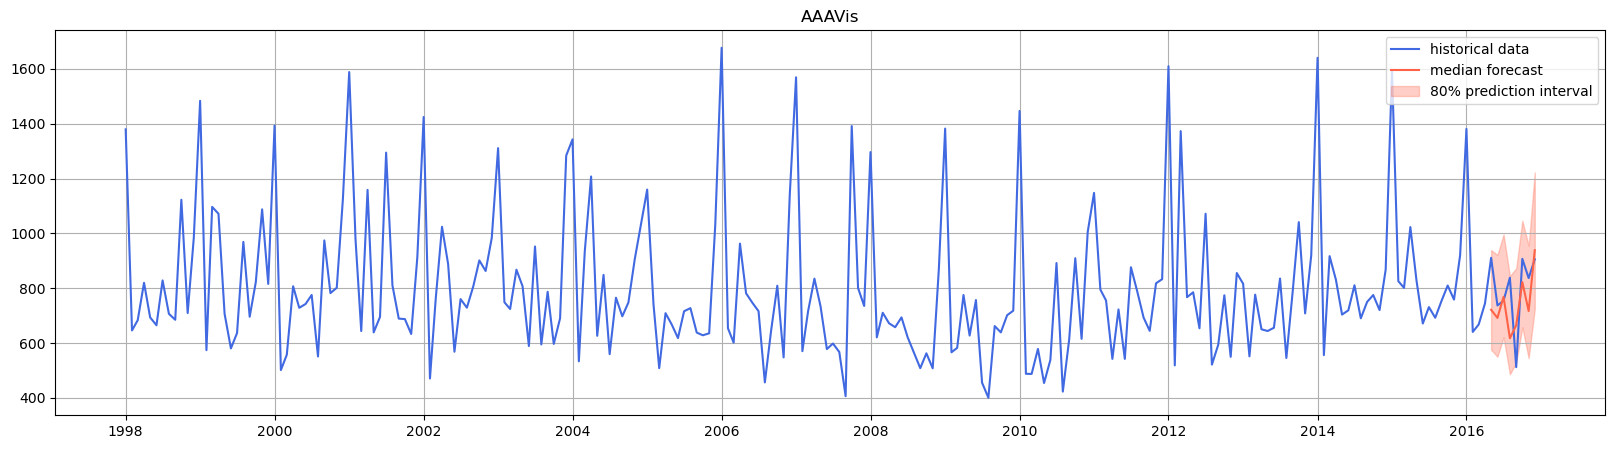

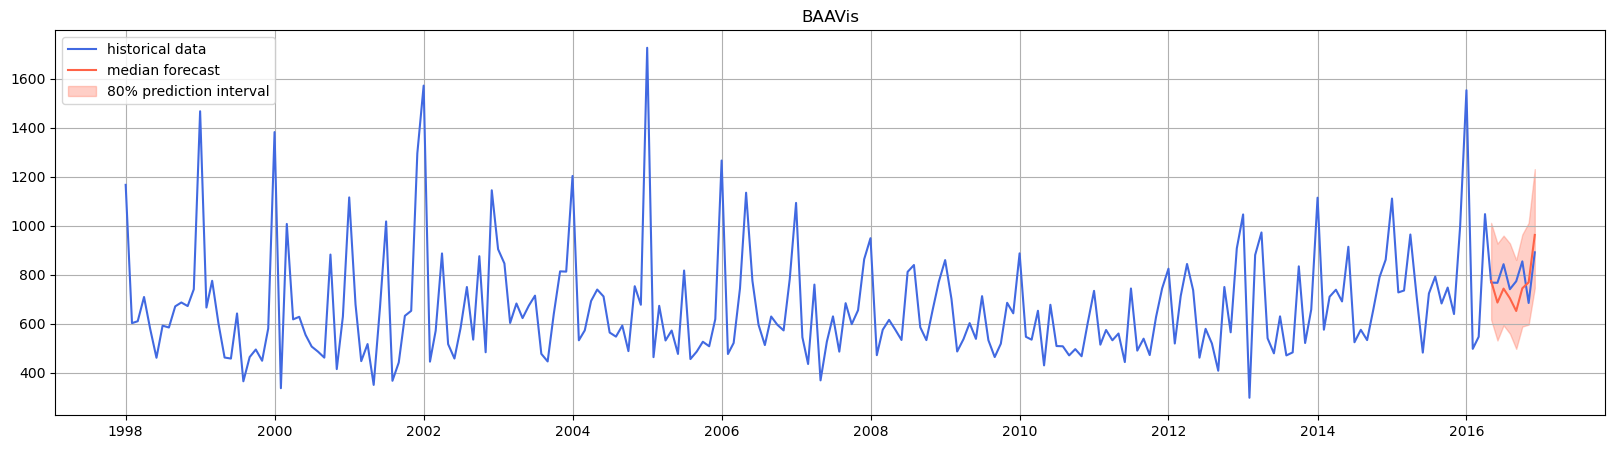

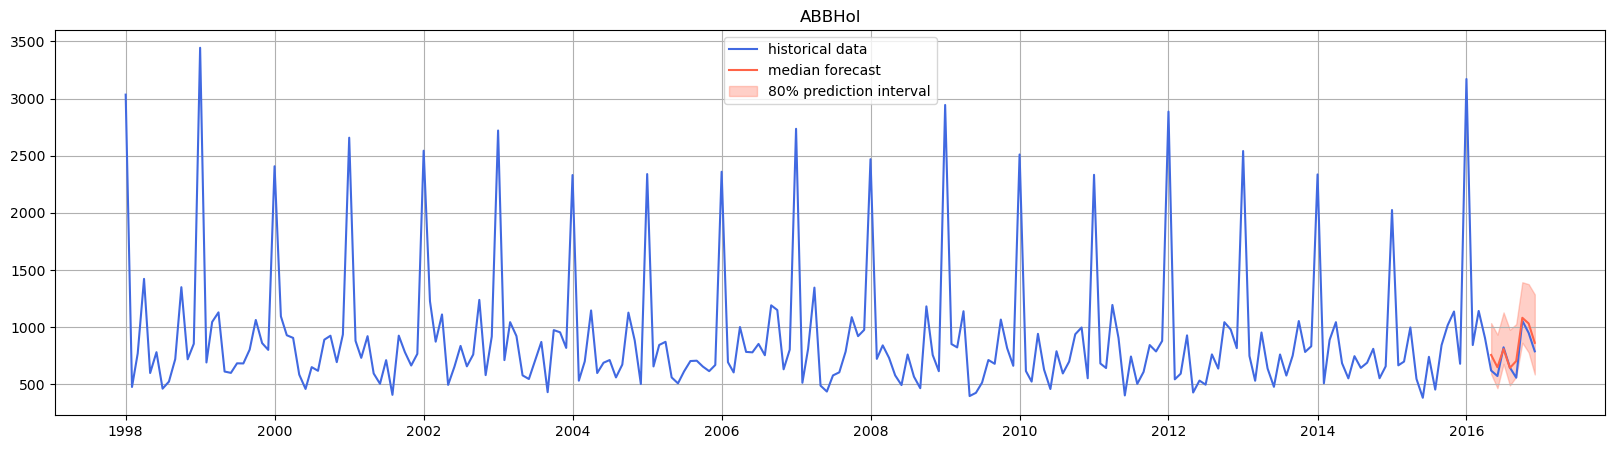

In [40]:
# get series ordered by volume in a descending way
series = test.groupby('unique_id')[TARGET].sum().reset_index().sort_values(by=TARGET, ascending=False)['unique_id'].tolist()

for ts in series[:3]:
    utils.plot_actuals_forecast(df[df["unique_id"]==ts], forecast_df[forecast_df["unique_id"] == ts].rename(columns={'ds':TIME_COL, 'timesfm-q-0.5': 'forecast', 'timesfm-q-0.1': 'forecast_lower', 'timesfm-q-0.9': 'forecast_upper'}), ts)

# Model Evaluation

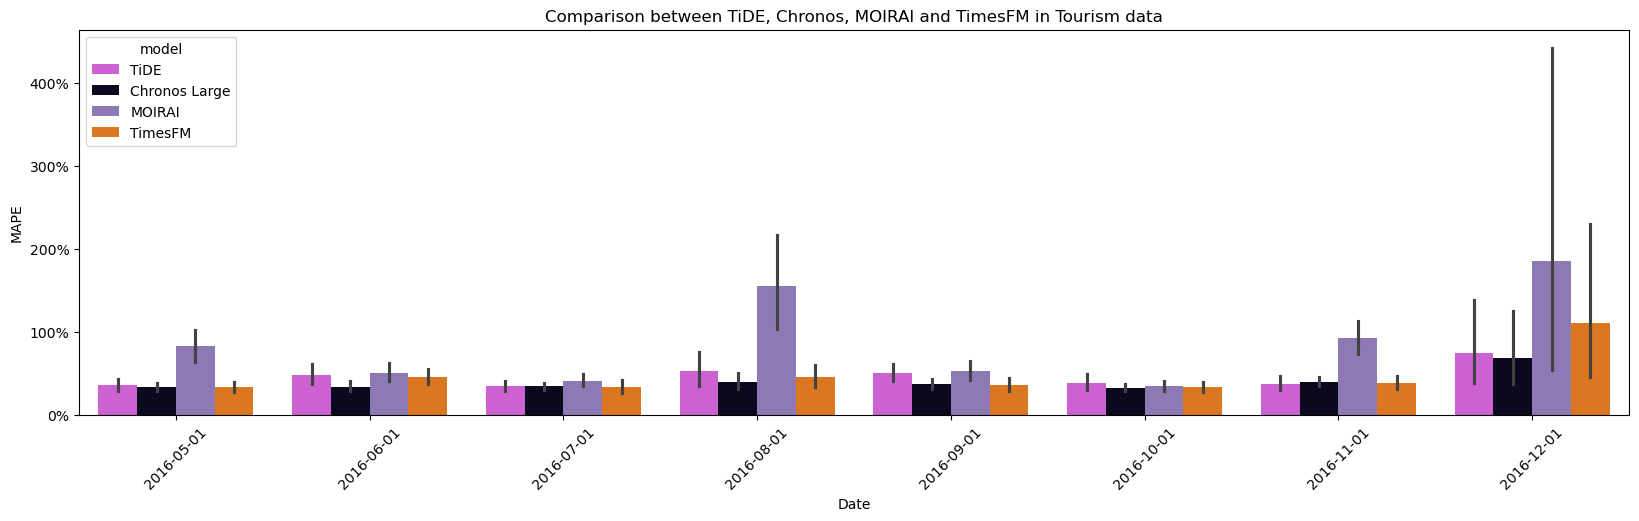

In [45]:
# load the forecast from our current model in production
tide_model_df = pd.read_csv('data/tide.csv', parse_dates=[TIME_COL])
chronos_large_df = pd.read_csv('data/chronos_large.csv', parse_dates=[TIME_COL])
moirai_df = pd.read_csv('data/moirai.csv', parse_dates=[TIME_COL])
timesfm_df = pd.read_csv('data/timesfm.csv', parse_dates=[TIME_COL])

# merge data frames with forecast and actuals
model_eval_df = pd.merge(test[['unique_id', TIME_COL, TARGET]], tide_model_df[['unique_id', TIME_COL, 'TiDE']], on=['unique_id', TIME_COL], how='inner')
model_eval_df = pd.merge(model_eval_df, chronos_large_df[['unique_id', TIME_COL, 'Chronos Large']], on=['unique_id', TIME_COL], how='inner')
model_eval_df = pd.merge(model_eval_df, moirai_df[['unique_id', TIME_COL, 'MOIRAI']], on=['unique_id', TIME_COL], how='inner')
model_eval_df = pd.merge(model_eval_df, timesfm_df[['unique_id', TIME_COL, 'TimesFM']], on=['unique_id', TIME_COL], how='inner')

# check performance for top 100 series
top_100 = df.groupby(['unique_id']).agg({TARGET: 'sum'}).reset_index().sort_values(by=TARGET, ascending=False).head(100)

utils.plot_model_comparison(model_eval_df[model_eval_df['unique_id'].isin(top_100['unique_id'])])